##**Pregunta 2**

Genere de manera aleatoria imagenes de el tipo de residuo solido que le toco aportar para el dataset.

Enlace de github[aqui](https://github.com/Abril2212/IA-BerriosAbril)

Enlace del dataset [aqui](https://drive.google.com/drive/folders/1tSmYwWvKtCykH35vqb5V6_oZBb5m49vC?usp=sharing)

Utilizando Deep Convolutional Generative Adversarial Networks (DCGANs) para este ejercicio.GAN continene:


*  Generador: el generador genera nuevas instancias de datos que son "similares" a los datos de entrenamiento, en nuestro caso imágenes de botellas_plastico. El generador toma un vector latente aleatorio y genera una imagen "falsa" del mismo tamaño que nuestra imagen remodelada de botellas_plastico. 
*   Discriminador: el discriminador evalúa la autenticidad de las imágenes proporcionadas; clasifica las imágenes del generador y la imagen original. El discriminador toma la verdad de las imágenes falsas y genera la estimación de probabilidad que oscila entre 0 y 1.



# 1.**Acceder al Drive e importar librerias**

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np # linear algebra
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import os
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape

import tensorflow as tf
from tensorflow.keras.utils import plot_model

Colocar un array que contenga las imagenes de las cuales se sacara del dataset y las cuales utilizaremos

In [60]:
all = []
full_path = "/content/drive/MyDrive/dataset_basura/botellas_plasticas"

In [61]:
for path in os.listdir(full_path):
  if '.jpg' in path:
    all.append(os.path.join(full_path, path))   
image_path = all[0:1000]
print(len(image_path))

1000


In [62]:
#constantes del modelo
PLOTS_DPI = 300


El método de recorte del módulo Imagen toma cuatro coordenadas como entrada.
La derecha también se puede representar como (izquierda+ancho) e inferior se pueden representar como (superior+alto)

In [63]:
cropping_box = (30, 55, 500, 575)
training_images = [np.array((Image.open(path).crop(cropping_box)).resize((64,64))) for path in image_path]
for i in range(len(training_images)):
    training_images[i] = ((training_images[i] - training_images[i].min())/(255 - training_images[i].min()))
    
training_images = np.array(training_images)
print(training_images.shape)

(1000, 64, 64, 3)


<Figure size 720x720 with 0 Axes>

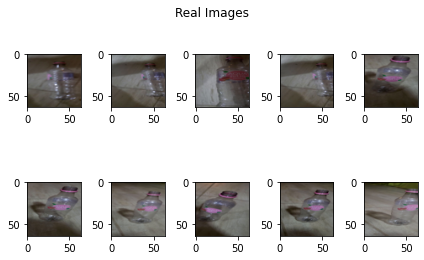

In [64]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=8

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(training_images[idx].reshape(64,64,3))            
            idx+=6
            
plt.tight_layout()
plt.show()

# **Genetator**

In [65]:
noise_shape = 100
def generator_model():
  generator=Sequential()
  generator.add(Dense(4*4*512, input_shape=[noise_shape]))
  generator.add(Reshape([4,4,512]))
  generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                  activation='sigmoid'))
  return generator
generator = generator_model()
generator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 8, 8, 256)        2097408   
 Transpose)                                                      
                                                                 
 batch_normalization_16 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 16, 16, 128)    

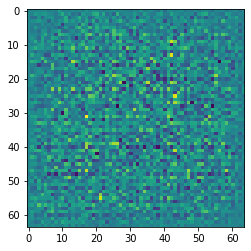

In [66]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
# print(generated_image)
plt.imshow(generated_image[0, :, :, 0])

# **Descriminator**

In [67]:
def discriminator_model():
  discriminator = Sequential()
  discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=[64,64, 3]))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.4))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_19 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                     

In [68]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')
GAN.layers
GAN.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 64, 64, 3)         3585219   
                                                                 
 sequential_13 (Sequential)  (None, 1)                 55361     
                                                                 
Total params: 3,640,580
Trainable params: 3,584,323
Non-trainable params: 56,257
_________________________________________________________________


Currently training on Epoch 1
	Currently training on batch number 0 of 15


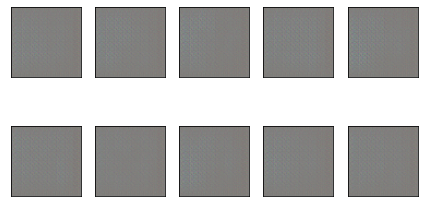

Epoch: 1,  Loss: D_real = 0.483, D_fake = 0.288,  G = 0.088
Currently training on Epoch 2
	Currently training on batch number 0 of 15
Epoch: 2,  Loss: D_real = 0.551, D_fake = 0.641,  G = 0.022
Currently training on Epoch 3
	Currently training on batch number 0 of 15
Epoch: 3,  Loss: D_real = 0.185, D_fake = 0.237,  G = 0.222
Currently training on Epoch 4
	Currently training on batch number 0 of 15
Epoch: 4,  Loss: D_real = 0.232, D_fake = 0.295,  G = 0.068
Currently training on Epoch 5
	Currently training on batch number 0 of 15
Epoch: 5,  Loss: D_real = 0.065, D_fake = 4.020,  G = 3.999
Currently training on Epoch 6
	Currently training on batch number 0 of 15
Epoch: 6,  Loss: D_real = 0.933, D_fake = 0.587,  G = 10.888
Currently training on Epoch 7
	Currently training on batch number 0 of 15
Epoch: 7,  Loss: D_real = 0.097, D_fake = 0.024,  G = 16.978
Currently training on Epoch 8
	Currently training on batch number 0 of 15
Epoch: 8,  Loss: D_real = 0.041, D_fake = 0.094,  G = 14.651

KeyboardInterrupt: ignored

In [69]:
epochs = 50
batch_size = 64
loss_from_discriminator_model=[]
loss_from_generator_model=[]
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently training on Epoch {epoch+1}")
    for i in range(training_images.shape[0]//batch_size):
      if (i)%100 == 0:
            print(f"\tCurrently training on batch number {i} of {len(training_images)//batch_size}")
      noise=np.random.uniform(-1,1,size=[batch_size, noise_shape])
      gen_image = generator.predict_on_batch(noise)
      train_dataset = training_images[i*batch_size:(i+1)*batch_size]
      train_labels_real=np.ones(shape=(batch_size,1))
      discriminator.trainable = True
      d_loss_real = discriminator.train_on_batch(train_dataset,train_labels_real)
      train_labels_fake=np.zeros(shape=(batch_size,1))
      d_loss_fake = discriminator.train_on_batch(gen_image,train_labels_fake)
      noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
      train_label_fake_for_gen_training =np.ones(shape=(batch_size,1))
      discriminator.trainable = False
      g_loss = GAN.train_on_batch(noise, train_label_fake_for_gen_training)
      loss_from_discriminator_model.append(d_loss_real+d_loss_fake)
      loss_from_generator_model.append(g_loss)
    if epoch % 50 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))
        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show()
    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss_real, d_loss_fake, g_loss))
print('Training completed with all epochs')

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

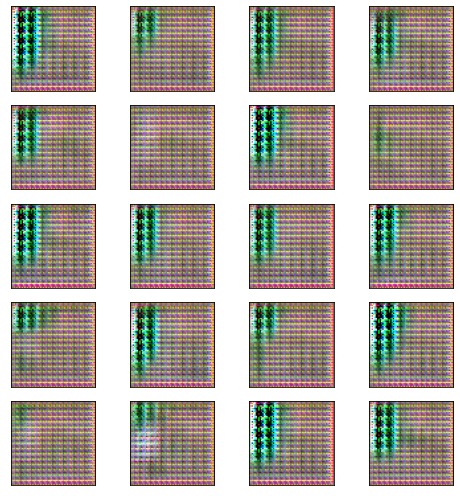

In [70]:
noise = np.random.uniform(-1,1,size=[100,noise_shape])
im= generator.predict(noise)
for i in range(5):
  plt.figure(figsize=(7,7))   
for k in range(20):
          noise=np.random.uniform(-1,1,size=[100,noise_shape])
          im=generator.predict(noise) 
          plt.subplot(5, 4, k+1)
          plt.imshow(im[k].reshape(64,64,3))
          plt.xticks([])
          plt.yticks([])
plt.tight_layout()
plt.show()